In [67]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

Elegimos el dataset de pinguinos y buscaremos modelar la longitud de las aletas. Para esto haremos dos modelos, uno de ellos jerárquico 

In [79]:
df = pd.read_csv("../datos/penguins.csv").dropna()
df.groupby(["species"])["flipper_length"].describe()

flipper  = df["flipper_length"].values
species = df["species"].values
species = pd.Categorical(df["species"]).codes

min_valor = 8
max_valor = 50
refs = {"Aleta pinguino pequeño teorico":min_valor,
        "Aleta pinguino grande teorico":max_valor}

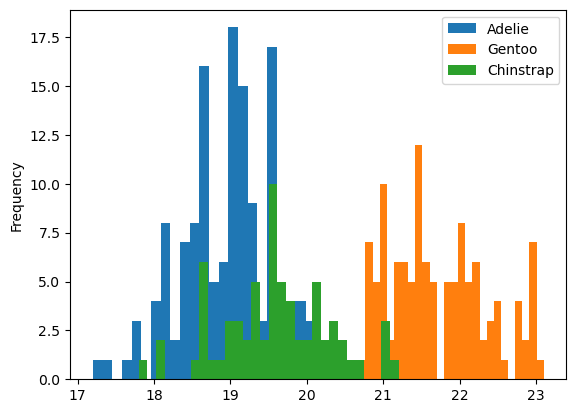

In [41]:
df[df["species"] == "Adelie"]["flipper_length"].plot(kind="hist", bins=30, label="Adelie")
df[df["species"] == "Gentoo"]["flipper_length"].plot(kind="hist", bins=30, label = "Gentoo")
df[df["species"] == "Chinstrap"]["flipper_length"].plot(kind="hist", bins=30, label = "Chinstrap")
plt.legend()

In [42]:
# df[(df["species"] == "Adelie") & (df["island"]=="Torgersen")]["flipper_length"].plot(kind="hist", bins=30, label="Torgersen")
# df[(df["species"] == "Adelie") & (df["island"]=="Biscoe")]["flipper_length"].plot(kind="hist", bins=30, label="Biscoe")
# df[(df["species"] == "Adelie") & (df["island"]=="Dream")]["flipper_length"].plot(kind="hist", bins=30, label="Dream")
# plt.legend()


Decidimos armar nuestro primer modelo sin disrciminar por especie. Proponemos que la longitud de la aleta siga una distribución Gamma. Teniendo en cuenta los valores teóricos decidimos modelar la media de la distribucion con una distribucion Normal(30,5) ($ \frac{aleta_{max} + aleta_{min}}{2}$) y la escala con una distribucion HalfNormal(5)

In [115]:
with pm.Model() as model_1:
    mu = pm.Normal("mu", mu= 29, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    y = pm.Gamma("y", mu=mu, sigma=sigma, observed=flipper)
    trace_1 = pm.sample(progressbar=False)
    trace_1.extend(pm.sample_prior_predictive(samples=100))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Sampling: [mu, sigma, y]


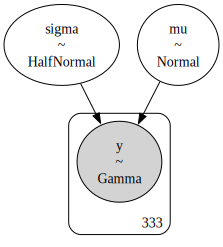

In [116]:
model_1.to_graphviz()

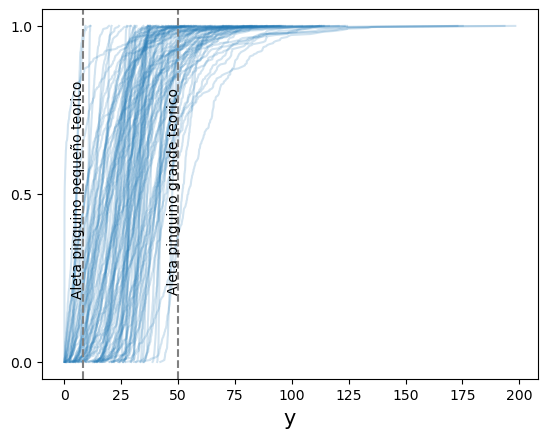

In [117]:
fig, ax = plt.subplots()
az.plot_ppc(trace_1, group="prior", kind="cumulative", mean=False, legend=False, ax = ax)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-5, 0.5-(len(key)/100), key, rotation=90)

Como vemos que tenemos muchos valores sin sentido, decifimos modificar los parámetros del prior.

In [163]:
with pm.Model() as model_1:
    mu = pm.Normal("mu", mu=29, sigma=5)
    sigma = pm.HalfNormal("sigma", sigma=5)
    
    y = pm.Gamma("y", mu=mu, sigma=sigma, observed=flipper)
    trace_1 = pm.sample(idata_kwargs={"log_likelihood":True},progressbar=False)
    trace_1.extend(pm.sample_prior_predictive(samples=100))
    trace_1.extend(pm.sample_posterior_predictive(trace_1));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Sampling: [mu, sigma, y]
Sampling: [y]


Output()

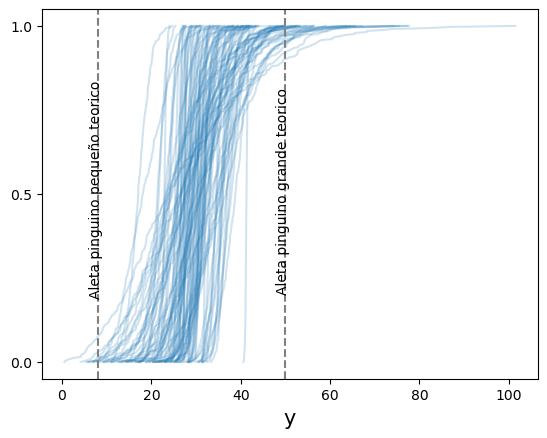

In [121]:
fig, ax = plt.subplots()
az.plot_ppc(trace_1, group="prior", kind="cumulative", mean=False, legend=False, ax = ax)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-2, 0.5-(len(key)/100), key, rotation=90)

Viendo nuestro prior predictive, consideramos que es un prior poco informativo ya que a pesar de tener valores sin mucho sentido, nos mantenemos en el orden de magnitud correcto

Posterior predictive checks:

<Axes: xlabel='y'>

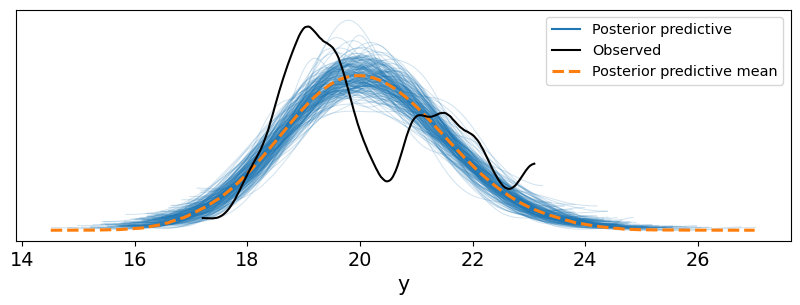

In [125]:
az.plot_ppc(trace_1, figsize=(10, 3), num_pp_samples=200)

<Axes: title={'center': 'y'}>

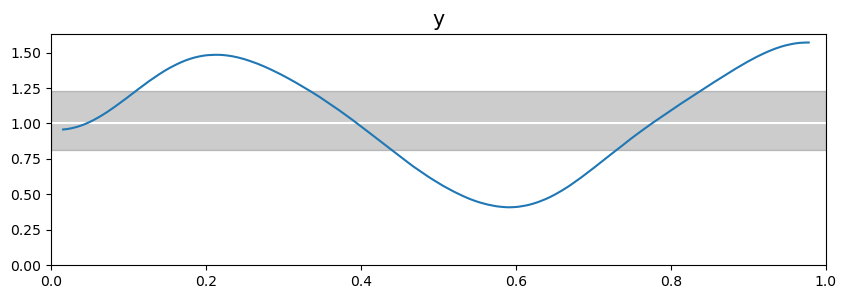

In [126]:
az.plot_bpv(trace_1, figsize=(10, 3))

La posterior predictive es muy diferente a la observada, asique concluimos que el modelo no ajusta correctamente. Proponemos pensar un nuevo modelo que incorpore las distintas especies de pingüinos.

In [153]:
cat_encode = pd.Categorical(df['species'])
cat_encode_island = pd.Categorical(df['island'])
idx = cat_encode.codes
coords = {"species": cat_encode.categories, "species_flat": cat_encode.categories[idx]}

In [160]:
with pm.Model(coords=coords) as model_2:
    
    mu = pm.Normal("mu", mu=29, sigma=5, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_flat")
    trace_2 = pm.sample(idata_kwargs={"log_likelihood":True},progressbar=False)
    trace_2.extend(pm.sample_prior_predictive(samples=100))
    trace_2.extend(pm.sample_posterior_predictive(trace_2));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Sampling: [mu, sigma, y]
Sampling: [y]


Output()

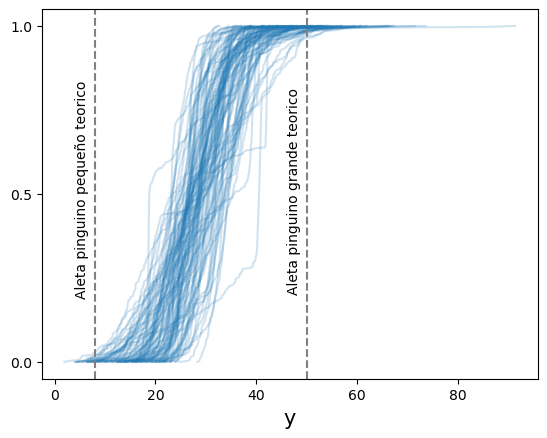

In [135]:
fig, ax = plt.subplots()
az.plot_ppc(trace_2, group="prior", kind="cumulative", mean=False, legend=False, ax = ax)

for key, val in refs.items():
    ax.axvline(val, ls="--", color="0.5")
    ax.text(val-4, 0.5-(len(key)/100), key, rotation=90)

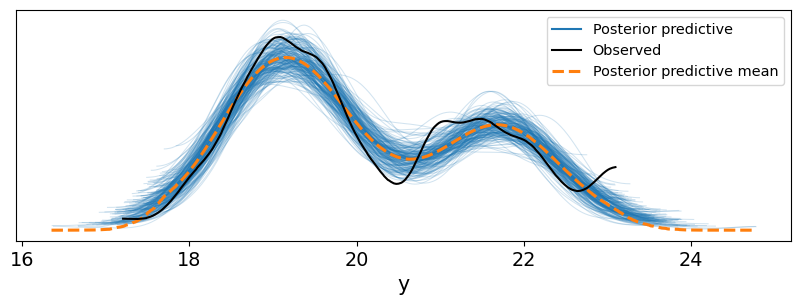

In [145]:
az.plot_ppc(trace_2, figsize=(10, 3), num_pp_samples=200);

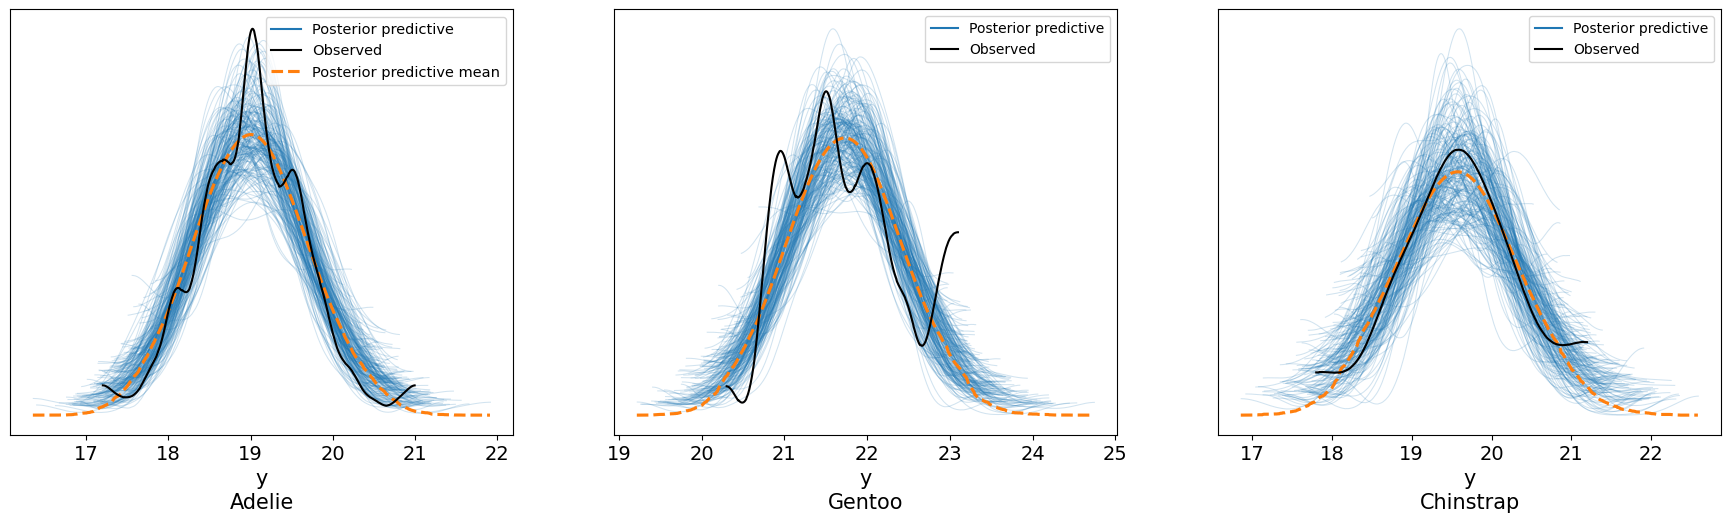

In [144]:
az.plot_ppc(trace_2, coords={"species_flat": [cat_encode.categories]}, flatten=[], num_pp_samples=200);

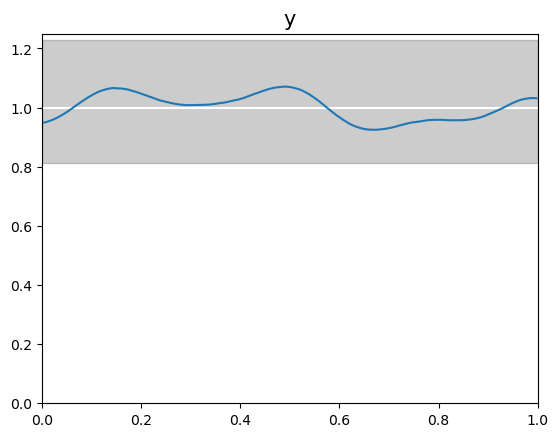

In [148]:
az.plot_bpv(trace_2);

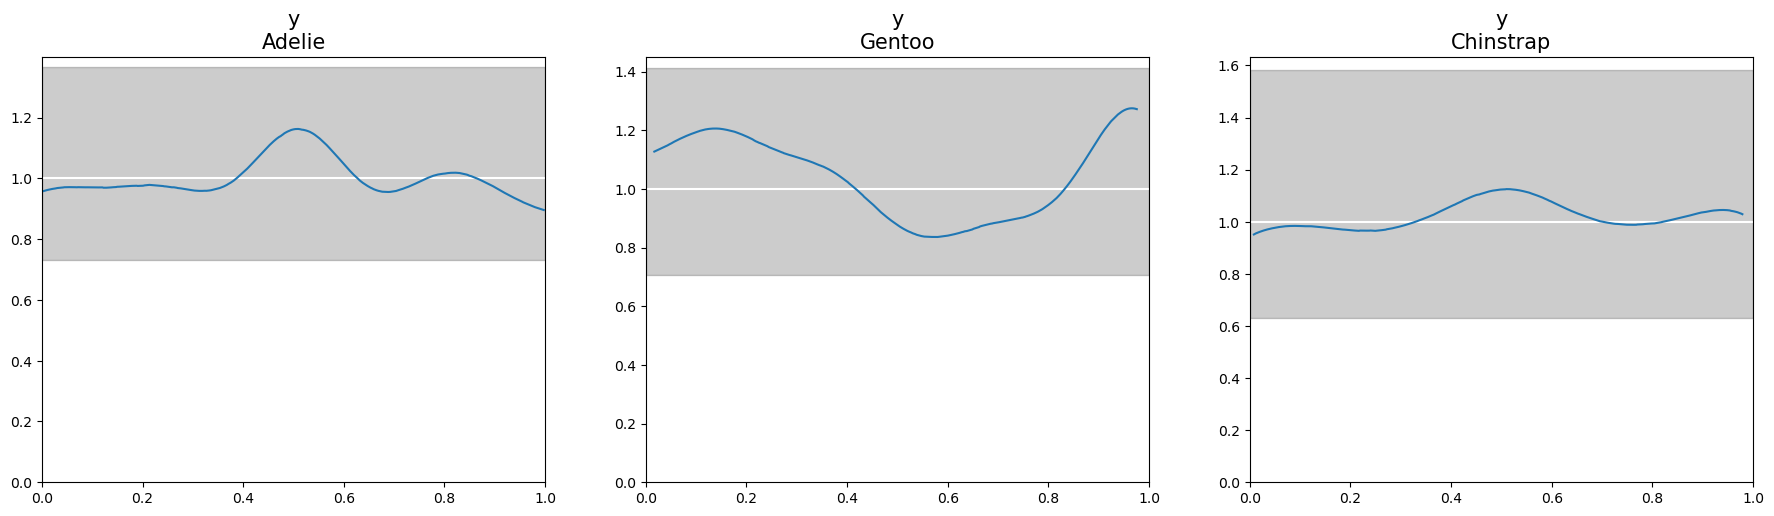

In [150]:
az.plot_bpv(trace_2, coords={"species_flat": [cat_encode.categories]}, flatten=[]);

Este modelo captura bien las distribuciones del tamaño de las aletas diferenciando por especie

## Modelo Jerárquico

Para comparar definimos un nuevo modelo, similar al anterior pero con una estructura jerárquica.


In [159]:
with pm.Model(coords=coords) as model_2_j:
    mu_mu = pm.Normal("mu_mu", mu=29, sigma=5)
    sigma_mu = pm.HalfNormal("sigma_mu", sigma=5)

    mu = pm.Normal("mu", mu=mu_mu, sigma=sigma_mu, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_flat")
    trace_2_j = pm.sample(idata_kwargs={"log_likelihood":True},progressbar=False)
    trace_2_j.extend(pm.sample_prior_predictive(samples=100))
    trace_2_j.extend(pm.sample_posterior_predictive(trace_2_j));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu, sigma_mu, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [mu, mu_mu, sigma, sigma_mu, y]
Sampling: [y]


Output()

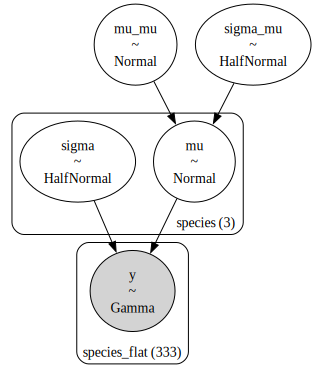

In [157]:
model_2_j.to_graphviz()

In [164]:
az.compare({"model_1": trace_1,"model_2": trace_2, "model_2_j": trace_2_j})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_2_j,0,-341.252906,5.522908,0.000000,1.000000e+00,12.634629,0.000000,False,log
model_2,1,-341.401915,5.650454,0.149009,0.000000e+00,12.612273,0.033812,False,log
model_1,2,-583.568555,1.518855,242.315649,6.661338e-16,9.391069,12.499135,False,log


In [166]:
df["species_island"] = df["species"] + " - " + df["island"]

cat_encode = pd.Categorical(df['species_island'])
idx = cat_encode.codes
coords = {"species_island": cat_encode.categories, "species_island_flat": cat_encode.categories[idx]}


In [167]:
with pm.Model(coords=coords) as model_3:
    
    mu = pm.Normal("mu", mu=29, sigma=5, dims="species_island")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species_island")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_island_flat")
    trace_3 = pm.sample(idata_kwargs={"log_likelihood":True},progressbar=False)
    trace_3.extend(pm.sample_prior_predictive(samples=100))
    trace_3.extend(pm.sample_posterior_predictive(trace_3));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Sampling: [mu, sigma, y]
Sampling: [y]


Output()

In [168]:
az.compare({"model_1": trace_1,"model_2": trace_2, "model_2_j": trace_2_j, "model_3": trace_3})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_2_j,0,-341.252906,5.522908,0.000000,0.968866,12.634629,0.000000,False,log
model_2,1,-341.401915,5.650454,0.149009,0.000000,12.612273,0.033812,False,log
model_3,2,-343.429486,9.710703,2.176580,0.031134,12.662071,2.180625,False,log
model_1,3,-583.568555,1.518855,242.315649,0.000000,9.391069,12.499135,False,log


In [207]:
with pm.Model(coords=coords) as model_3j:
    mu_mu = pm.Normal("mu_mu", mu=29, sigma=5)
    sigma_mu = pm.HalfNormal("sigma_mu", sigma=5)

    mu = pm.Normal("mu", mu=mu_mu, sigma=sigma_mu, dims="species_island")
    sigma = pm.HalfNormal("sigma", sigma=5, dims="species_island")
    
    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=flipper, dims="species_island_flat")
    trace_3j = pm.sample(idata_kwargs={"log_likelihood":True},progressbar=False)
    trace_3j.extend(pm.sample_prior_predictive(samples=100))
    trace_3j.extend(pm.sample_posterior_predictive(trace_3j));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu, sigma_mu, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [mu, mu_mu, sigma, sigma_mu, y]
Sampling: [y]


Output()

In [171]:
az.compare({"model_1": trace_1,"model_2": trace_2, "model_2_j": trace_2_j, "model_3": trace_3, "model_3j": trace_3j})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_2_j,0,-341.252906,5.522908,0.000000,0.968727,12.634629,0.000000,False,log
model_2,1,-341.401915,5.650454,0.149009,0.000000,12.612273,0.033812,False,log
model_3j,2,-343.396712,9.689589,2.143806,0.000000,12.679434,2.164436,False,log
model_3,3,-343.429486,9.710703,2.176580,0.031273,12.662071,2.180625,False,log
model_1,4,-583.568555,1.518855,242.315649,0.000000,9.391069,12.499135,False,log


Nos quedamos con el model2_j. Hacemos diagnosticos de muestro

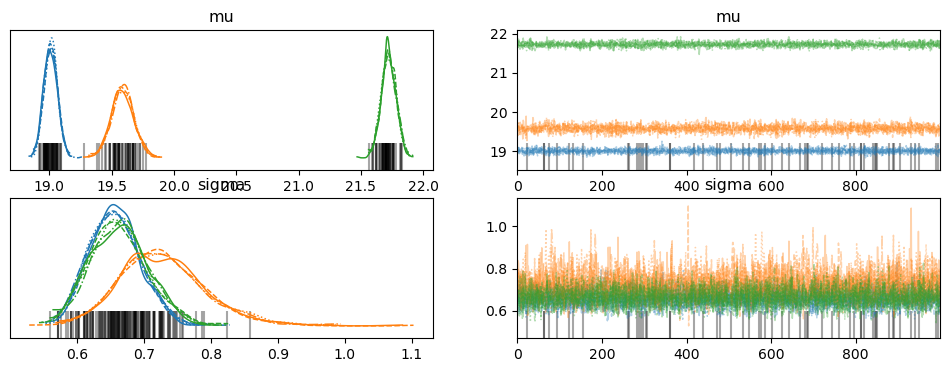

In [186]:
az.plot_trace(trace_2_j, var_names=["mu", "sigma"], compact=True);

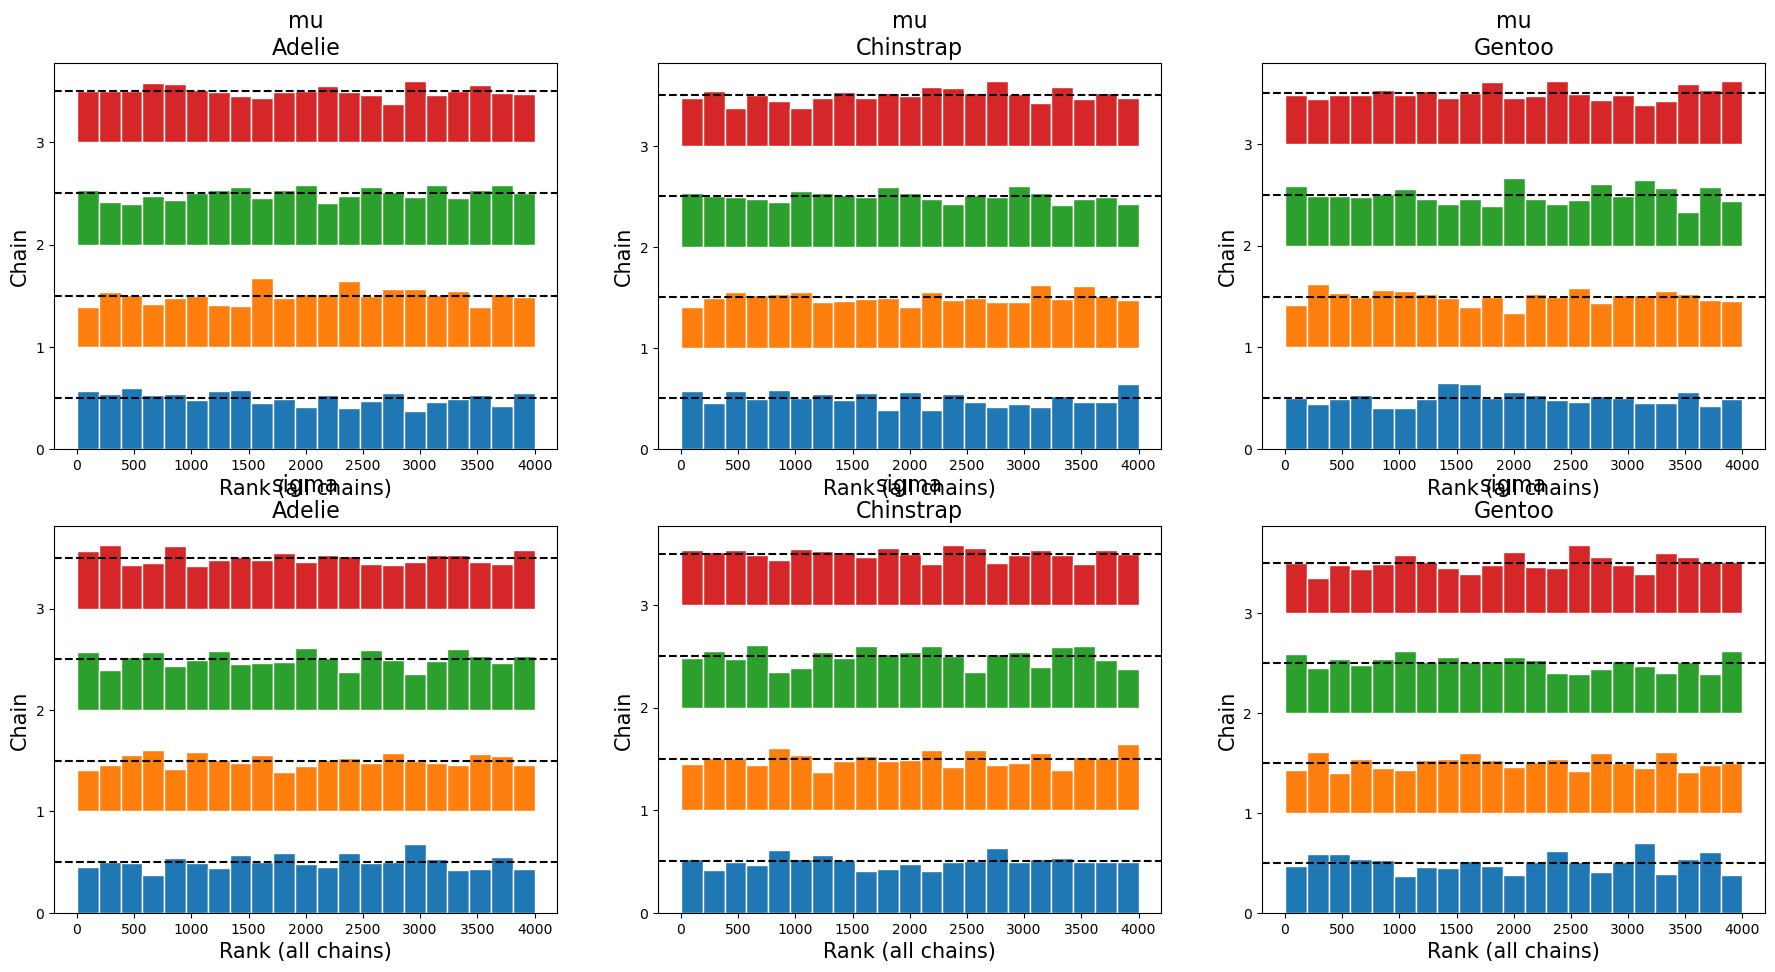

In [195]:
az.plot_rank(trace_2_j, var_names=["mu", "sigma"]);

In [198]:
az.rhat(trace_2_j, var_names=["mu", "sigma"])

<xarray.Dataset> Size: 156B
Dimensions:  (species: 3)
Coordinates:
  * species  (species) <U9 108B 'Adelie' 'Chinstrap' 'Gentoo'
Data variables:
    mu       (species) float64 24B 1.002 1.0 0.9999
    sigma    (species) float64 24B 1.001 1.001 1.001

In [199]:
az.ess(trace_2_j, var_names=["mu", "sigma"])

<xarray.Dataset> Size: 156B
Dimensions:  (species: 3)
Coordinates:
  * species  (species) <U9 108B 'Adelie' 'Chinstrap' 'Gentoo'
Data variables:
    mu       (species) float64 24B 3.833e+03 3.053e+03 3.885e+03
    sigma    (species) float64 24B 4.083e+03 3.476e+03 3.514e+03

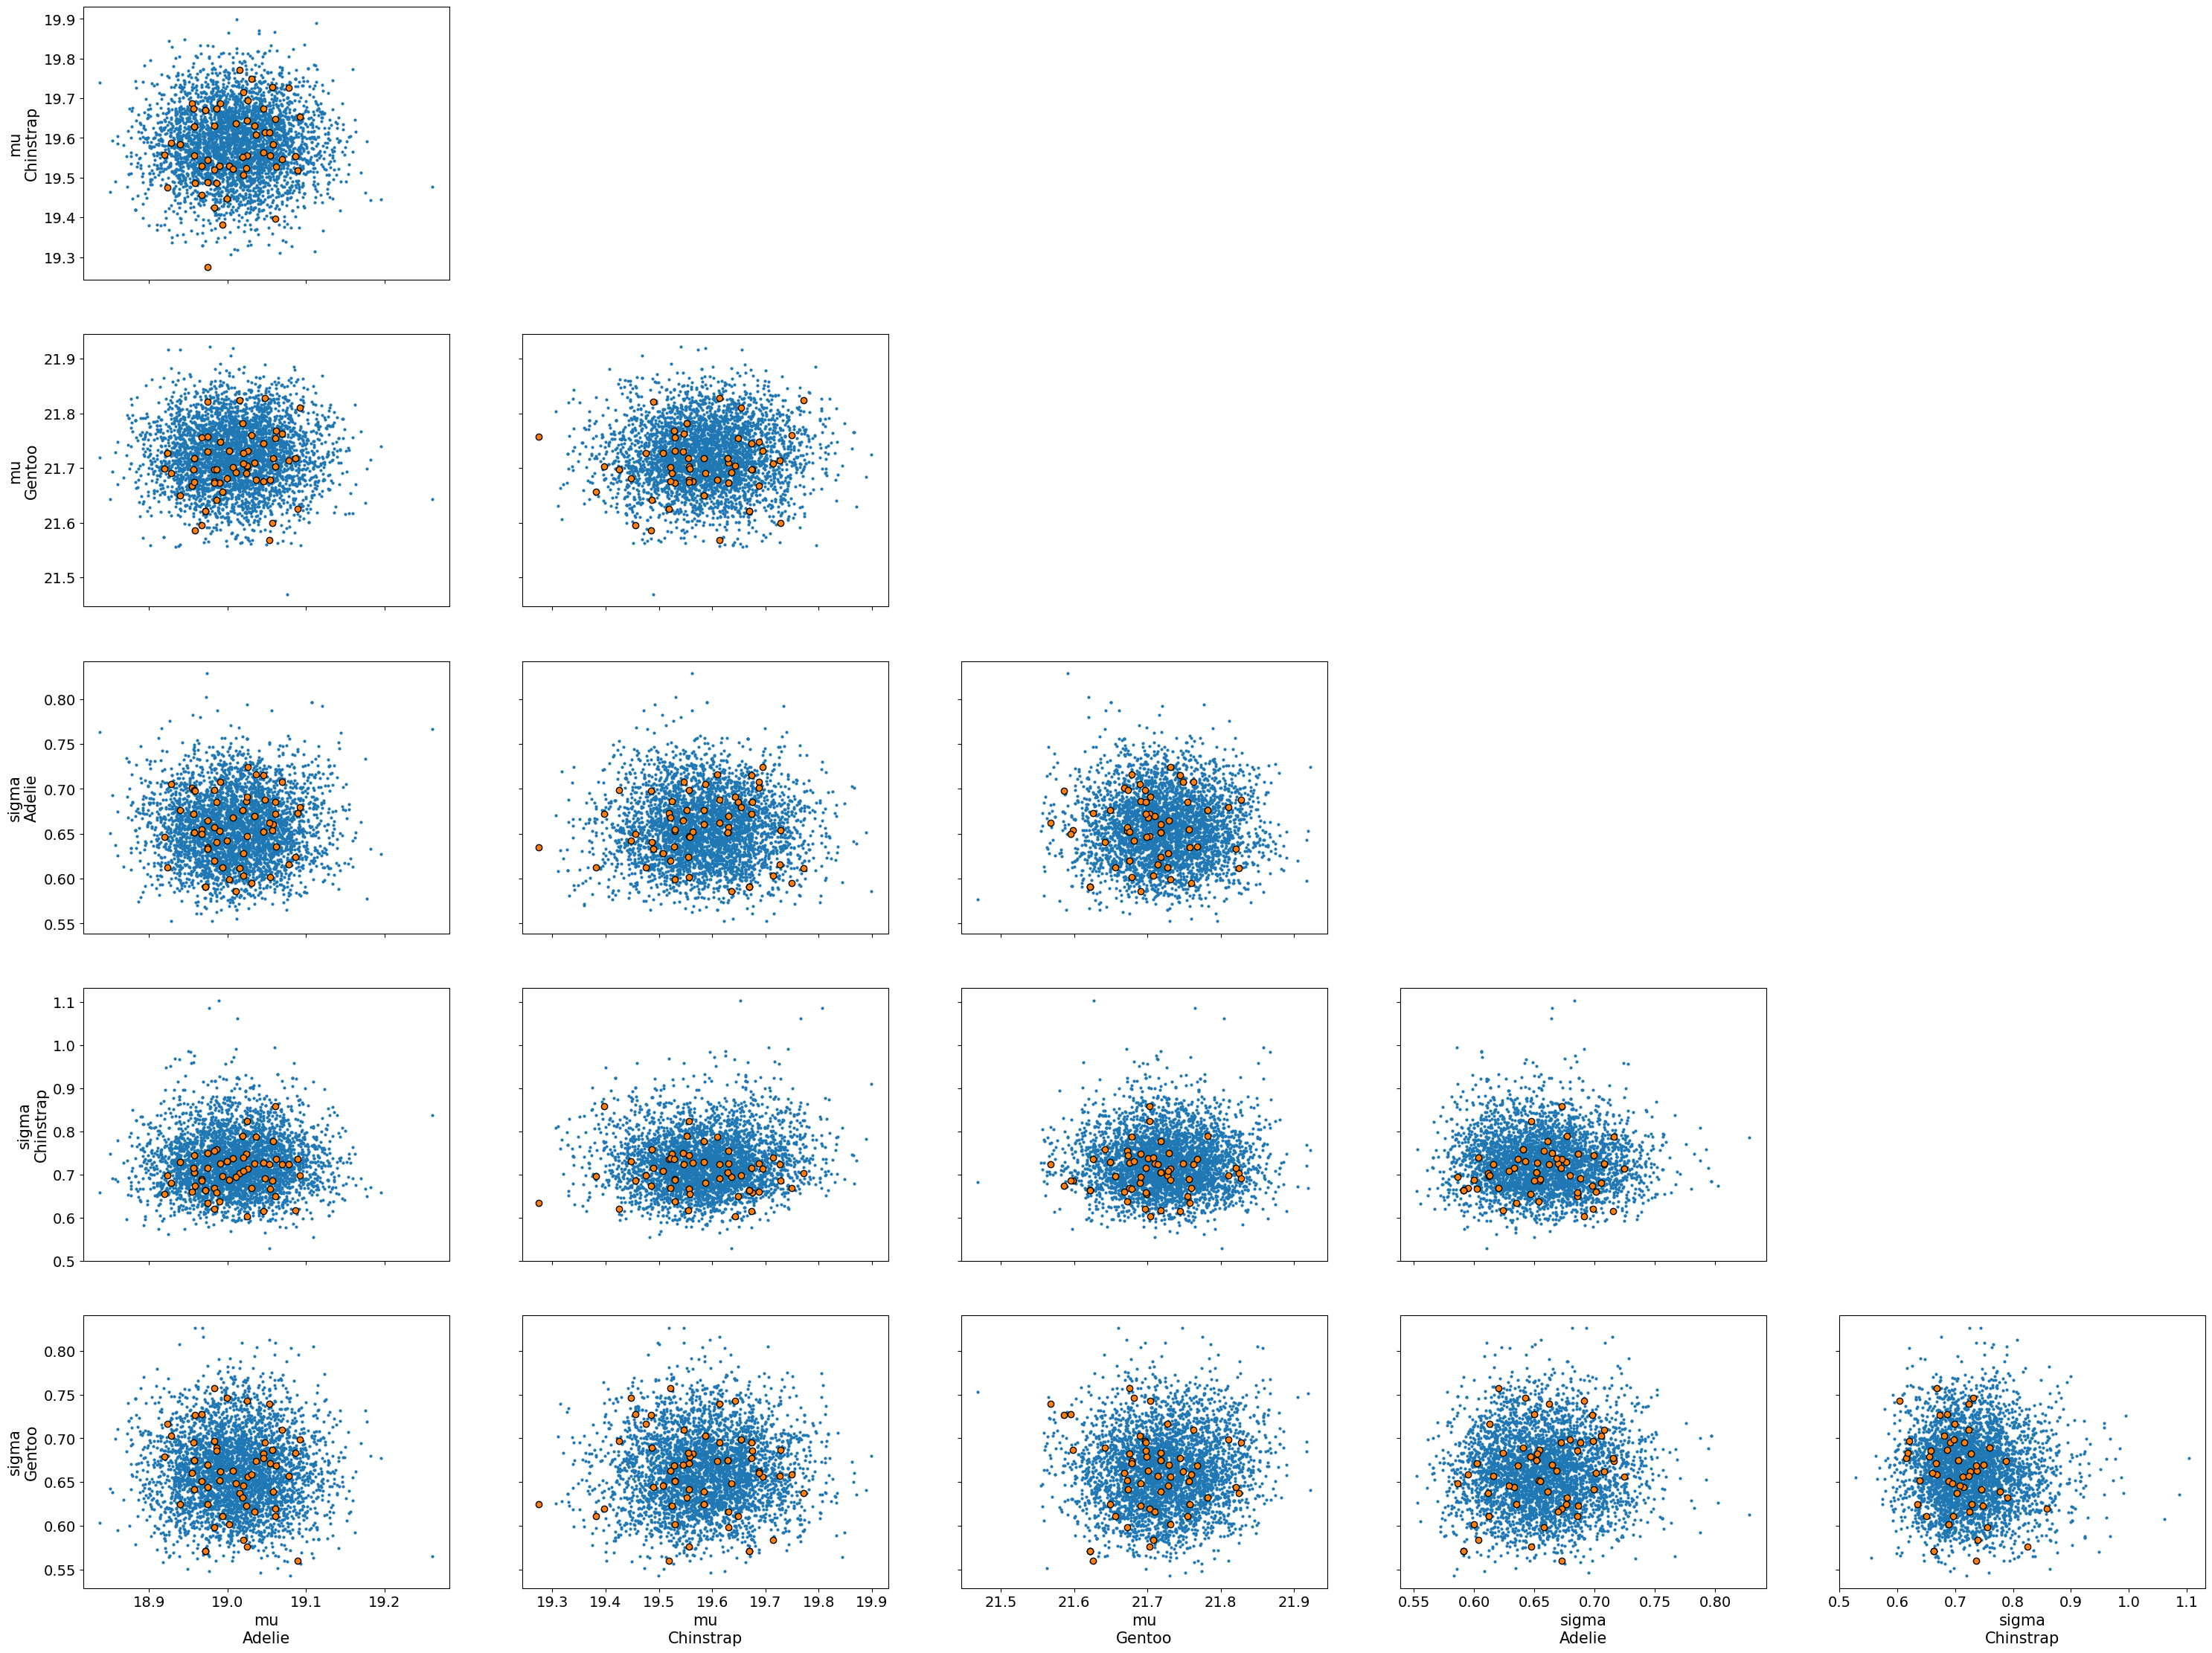

In [208]:
az.plot_pair(trace_2_j, var_names=['mu', 'sigma'], kind='scatter',
                 divergences=True, divergences_kwargs={'color':'C1'});

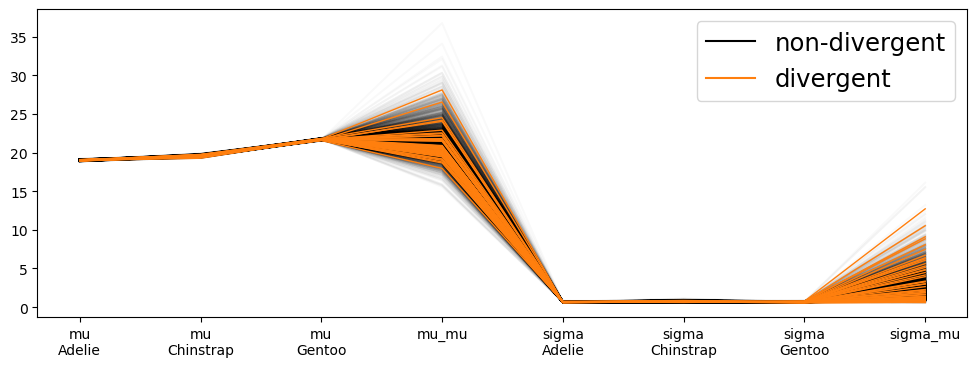

In [200]:
az.plot_parallel(trace_2_j, figsize=(12, 4));